# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
    #env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()
# env.close()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
class Model:
    def __init__(self, learning_rate, state_size, action_size, hidden_size):
        # Model input
        self.inputs = tf.placeholder(tf.float32, [None, state_size], name='inputs')
        self.actions = tf.placeholder(tf.int32, [None], name='actions')
        self.targetQs = tf.placeholder(tf.float32, [None], name='targetQs')

        # Model output
        fc1 = tf.contrib.layers.fully_connected(self.inputs, hidden_size)
        fc2 = tf.contrib.layers.fully_connected(fc1, hidden_size)
        self.actions_logits = tf.contrib.layers.fully_connected(fc2, action_size, activation_fn=None)

        # Model loss
        actions_labels = tf.one_hot(self.actions, action_size)
        Q = tf.reduce_max(self.actions_logits*actions_labels, axis=1)
        self.loss = tf.reduce_mean(tf.square(Q - self.targetQs))

        # Model update
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [9]:
graph = tf.reset_default_graph()
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)
memory = Memory(max_size=memory_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.add([state, action, reward, next_state, float(done)])
    state = next_state
    if done:
        state = env.reset()

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
episode_rewards_list = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    episode_reward = deque(maxlen=100) # running average    
    total_step = 0
    
    for ep in range(11111):
        total_reward = 0
        state = env.reset()
        
        while True:
            # env.render() #to watch the training
            # Explore or Exploit
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits,
                                         feed_dict={model.inputs: state.reshape([1, -1])})
                                          #feed_dict={model.inputs: state.reshape([1, *state.shape])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.add([state, action, reward, next_state, float(done)])
            total_reward += reward
            state = next_state
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            next_actions_logits = sess.run(model.actions_logits, feed_dict={model.inputs: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt],
                               feed_dict={model.inputs: states,
                                          model.targetQs: targetQs,
                                          model.actions: actions})
            if done:
                break
            
        # After each episode
        episode_reward.append(total_reward)
        episode_rewards_list.append((ep, np.mean(episode_reward)))
        rewards_list.append((ep, total_reward))
        print('Episode:{}'.format(ep),
              'MeanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'Loss:{:.4f}'.format(loss),
              'ExploreP:{:.4f}'.format(explore_p))
        if np.mean(episode_reward) >= 500:
            break
            
    # save the model at the end of all training episodes
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode:0 MeanR:15.0000 R:15.0 Loss:1.2776 ExploreP:0.9985
Episode:1 MeanR:36.5000 R:58.0 Loss:1.3697 ExploreP:0.9928
Episode:2 MeanR:31.0000 R:20.0 Loss:1.0164 ExploreP:0.9908
Episode:3 MeanR:29.0000 R:23.0 Loss:1.6375 ExploreP:0.9886
Episode:4 MeanR:30.4000 R:36.0 Loss:1.7714 ExploreP:0.9851
Episode:5 MeanR:33.5000 R:49.0 Loss:1.7270 ExploreP:0.9803
Episode:6 MeanR:32.1429 R:24.0 Loss:1.9787 ExploreP:0.9780
Episode:7 MeanR:29.8750 R:14.0 Loss:1.2731 ExploreP:0.9766
Episode:8 MeanR:29.8889 R:30.0 Loss:1.3357 ExploreP:0.9737
Episode:9 MeanR:29.1000 R:22.0 Loss:1.0870 ExploreP:0.9716
Episode:10 MeanR:28.0909 R:18.0 Loss:1.5011 ExploreP:0.9699
Episode:11 MeanR:27.1667 R:17.0 Loss:1.4852 ExploreP:0.9682
Episode:12 MeanR:26.0769 R:13.0 Loss:1.2022 ExploreP:0.9670
Episode:13 MeanR:25.3571 R:16.0 Loss:1.5702 ExploreP:0.9655
Episode:14 MeanR:25.5333 R:28.0 Loss:1.5831 ExploreP:0.9628
Episode:15 MeanR:24.6250 R:11.0 Loss:1.8559 ExploreP:0.9618
Episode:16 MeanR:26.9412 R:64.0 Loss:1.6367 Explor

Episode:141 MeanR:17.1300 R:17.0 Loss:132.8625 ExploreP:0.7635
Episode:142 MeanR:17.1800 R:15.0 Loss:101.1411 ExploreP:0.7624
Episode:143 MeanR:17.1600 R:10.0 Loss:94.6447 ExploreP:0.7616
Episode:144 MeanR:17.1900 R:14.0 Loss:80.1917 ExploreP:0.7605
Episode:145 MeanR:17.1000 R:9.0 Loss:3.3447 ExploreP:0.7599
Episode:146 MeanR:17.0200 R:20.0 Loss:132.8218 ExploreP:0.7584
Episode:147 MeanR:16.9700 R:14.0 Loss:3.2490 ExploreP:0.7573
Episode:148 MeanR:16.9000 R:14.0 Loss:45.8725 ExploreP:0.7563
Episode:149 MeanR:16.8700 R:11.0 Loss:2.7721 ExploreP:0.7555
Episode:150 MeanR:16.9000 R:12.0 Loss:1.7710 ExploreP:0.7546
Episode:151 MeanR:16.9500 R:18.0 Loss:96.2721 ExploreP:0.7532
Episode:152 MeanR:16.9700 R:14.0 Loss:133.1580 ExploreP:0.7522
Episode:153 MeanR:17.0300 R:22.0 Loss:90.5473 ExploreP:0.7506
Episode:154 MeanR:17.2100 R:29.0 Loss:38.0978 ExploreP:0.7484
Episode:155 MeanR:17.1500 R:14.0 Loss:183.3531 ExploreP:0.7474
Episode:156 MeanR:17.2600 R:21.0 Loss:47.2075 ExploreP:0.7458
Episode:

Episode:276 MeanR:18.5500 R:28.0 Loss:0.6906 ExploreP:0.6003
Episode:277 MeanR:18.5200 R:33.0 Loss:17.8088 ExploreP:0.5983
Episode:278 MeanR:18.8500 R:52.0 Loss:18.7954 ExploreP:0.5953
Episode:279 MeanR:18.8700 R:14.0 Loss:16.0681 ExploreP:0.5945
Episode:280 MeanR:19.1400 R:50.0 Loss:49.7976 ExploreP:0.5916
Episode:281 MeanR:19.2300 R:34.0 Loss:17.6562 ExploreP:0.5896
Episode:282 MeanR:19.4500 R:51.0 Loss:32.9374 ExploreP:0.5866
Episode:283 MeanR:19.5400 R:34.0 Loss:13.8839 ExploreP:0.5847
Episode:284 MeanR:19.5700 R:14.0 Loss:54.1393 ExploreP:0.5839
Episode:285 MeanR:19.5400 R:11.0 Loss:0.9259 ExploreP:0.5832
Episode:286 MeanR:19.2200 R:14.0 Loss:33.5690 ExploreP:0.5824
Episode:287 MeanR:19.2400 R:13.0 Loss:14.4738 ExploreP:0.5817
Episode:288 MeanR:19.2400 R:21.0 Loss:50.1080 ExploreP:0.5805
Episode:289 MeanR:19.8200 R:73.0 Loss:40.4426 ExploreP:0.5763
Episode:290 MeanR:19.8000 R:14.0 Loss:28.6577 ExploreP:0.5756
Episode:291 MeanR:19.7300 R:10.0 Loss:1.5068 ExploreP:0.5750
Episode:292

Episode:411 MeanR:27.5000 R:31.0 Loss:18.7211 ExploreP:0.4203
Episode:412 MeanR:27.1700 R:40.0 Loss:1.2300 ExploreP:0.4187
Episode:413 MeanR:27.2300 R:24.0 Loss:1.6036 ExploreP:0.4177
Episode:414 MeanR:27.2400 R:15.0 Loss:21.4667 ExploreP:0.4171
Episode:415 MeanR:27.2000 R:18.0 Loss:20.7246 ExploreP:0.4163
Episode:416 MeanR:27.3500 R:35.0 Loss:1.5559 ExploreP:0.4149
Episode:417 MeanR:27.4900 R:30.0 Loss:40.1087 ExploreP:0.4137
Episode:418 MeanR:27.6800 R:35.0 Loss:25.6769 ExploreP:0.4123
Episode:419 MeanR:28.2700 R:80.0 Loss:1.1665 ExploreP:0.4091
Episode:420 MeanR:28.2800 R:23.0 Loss:19.8593 ExploreP:0.4082
Episode:421 MeanR:28.7400 R:81.0 Loss:16.0471 ExploreP:0.4050
Episode:422 MeanR:28.8900 R:29.0 Loss:49.2613 ExploreP:0.4038
Episode:423 MeanR:29.0400 R:25.0 Loss:1.1913 ExploreP:0.4028
Episode:424 MeanR:29.4900 R:65.0 Loss:52.4274 ExploreP:0.4003
Episode:425 MeanR:29.7000 R:36.0 Loss:20.3484 ExploreP:0.3989
Episode:426 MeanR:29.7800 R:40.0 Loss:1.2676 ExploreP:0.3973
Episode:427 Me

Episode:546 MeanR:57.6600 R:28.0 Loss:37.3399 ExploreP:0.2073
Episode:547 MeanR:57.0300 R:27.0 Loss:1.3272 ExploreP:0.2067
Episode:548 MeanR:56.7300 R:26.0 Loss:1.7869 ExploreP:0.2062
Episode:549 MeanR:57.2900 R:92.0 Loss:1.3746 ExploreP:0.2044
Episode:550 MeanR:57.3000 R:33.0 Loss:29.5448 ExploreP:0.2038
Episode:551 MeanR:56.9600 R:40.0 Loss:1.2241 ExploreP:0.2030
Episode:552 MeanR:55.8100 R:30.0 Loss:1.6069 ExploreP:0.2024
Episode:553 MeanR:55.7200 R:33.0 Loss:29.8192 ExploreP:0.2018
Episode:554 MeanR:55.6700 R:33.0 Loss:1.0257 ExploreP:0.2012
Episode:555 MeanR:55.2000 R:36.0 Loss:1.7925 ExploreP:0.2005
Episode:556 MeanR:55.0000 R:23.0 Loss:47.1555 ExploreP:0.2000
Episode:557 MeanR:55.0000 R:33.0 Loss:1.0977 ExploreP:0.1994
Episode:558 MeanR:54.8000 R:25.0 Loss:104.4055 ExploreP:0.1989
Episode:559 MeanR:54.4900 R:30.0 Loss:1.2450 ExploreP:0.1984
Episode:560 MeanR:54.2300 R:16.0 Loss:1.8093 ExploreP:0.1981
Episode:561 MeanR:54.1500 R:26.0 Loss:1.7163 ExploreP:0.1976
Episode:562 MeanR:

Episode:679 MeanR:129.8000 R:183.0 Loss:0.4111 ExploreP:0.0585
Episode:680 MeanR:131.4600 R:204.0 Loss:0.3681 ExploreP:0.0575
Episode:681 MeanR:132.9700 R:193.0 Loss:0.3120 ExploreP:0.0566
Episode:682 MeanR:134.7400 R:204.0 Loss:0.4504 ExploreP:0.0556
Episode:683 MeanR:135.9800 R:162.0 Loss:30.8518 ExploreP:0.0549
Episode:684 MeanR:137.5600 R:216.0 Loss:0.2271 ExploreP:0.0539
Episode:685 MeanR:138.6900 R:218.0 Loss:1.1957 ExploreP:0.0530
Episode:686 MeanR:139.9600 R:167.0 Loss:0.3900 ExploreP:0.0523
Episode:687 MeanR:141.7000 R:215.0 Loss:0.7637 ExploreP:0.0514
Episode:688 MeanR:142.3800 R:161.0 Loss:0.3820 ExploreP:0.0507
Episode:689 MeanR:143.4900 R:190.0 Loss:0.6298 ExploreP:0.0500
Episode:690 MeanR:145.0300 R:206.0 Loss:0.5061 ExploreP:0.0491
Episode:691 MeanR:146.1900 R:169.0 Loss:0.6080 ExploreP:0.0485
Episode:692 MeanR:147.2700 R:192.0 Loss:0.3965 ExploreP:0.0478
Episode:693 MeanR:148.4100 R:157.0 Loss:0.1629 ExploreP:0.0472
Episode:694 MeanR:149.9600 R:205.0 Loss:0.3711 Explore

Episode:815 MeanR:332.7600 R:9.0 Loss:1.8742 ExploreP:0.0108
Episode:816 MeanR:327.8500 R:9.0 Loss:2.0621 ExploreP:0.0108
Episode:817 MeanR:322.9600 R:11.0 Loss:1.7683 ExploreP:0.0108
Episode:818 MeanR:322.1000 R:9.0 Loss:2.2566 ExploreP:0.0108
Episode:819 MeanR:321.2000 R:10.0 Loss:1.7103 ExploreP:0.0108
Episode:820 MeanR:319.8400 R:10.0 Loss:1.0368 ExploreP:0.0108
Episode:821 MeanR:319.2200 R:12.0 Loss:1.3913 ExploreP:0.0108
Episode:822 MeanR:318.5700 R:12.0 Loss:2.2937 ExploreP:0.0108
Episode:823 MeanR:313.7000 R:13.0 Loss:0.9163 ExploreP:0.0108
Episode:824 MeanR:308.8500 R:15.0 Loss:1.6313 ExploreP:0.0108
Episode:825 MeanR:307.8900 R:330.0 Loss:0.2666 ExploreP:0.0108
Episode:826 MeanR:305.9500 R:306.0 Loss:0.3051 ExploreP:0.0108
Episode:827 MeanR:301.1700 R:19.0 Loss:0.6204 ExploreP:0.0108
Episode:828 MeanR:296.4200 R:25.0 Loss:0.2522 ExploreP:0.0108
Episode:829 MeanR:291.5800 R:16.0 Loss:0.3680 ExploreP:0.0108
Episode:830 MeanR:286.7400 R:16.0 Loss:0.2292 ExploreP:0.0108
Episode:8

Episode:951 MeanR:16.1200 R:10.0 Loss:7.9347 ExploreP:0.0106
Episode:952 MeanR:16.1000 R:9.0 Loss:9.0243 ExploreP:0.0106
Episode:953 MeanR:16.0600 R:8.0 Loss:6.5015 ExploreP:0.0106
Episode:954 MeanR:15.9800 R:9.0 Loss:9.7835 ExploreP:0.0106
Episode:955 MeanR:15.9500 R:10.0 Loss:7.6360 ExploreP:0.0106
Episode:956 MeanR:15.9200 R:8.0 Loss:7.4785 ExploreP:0.0106
Episode:957 MeanR:15.9000 R:8.0 Loss:10.0670 ExploreP:0.0106
Episode:958 MeanR:15.8900 R:9.0 Loss:7.7663 ExploreP:0.0106
Episode:959 MeanR:15.8800 R:10.0 Loss:7.7830 ExploreP:0.0106
Episode:960 MeanR:15.8800 R:10.0 Loss:8.5516 ExploreP:0.0106
Episode:961 MeanR:15.9000 R:10.0 Loss:403.8188 ExploreP:0.0106
Episode:962 MeanR:15.8800 R:9.0 Loss:7.1573 ExploreP:0.0106
Episode:963 MeanR:15.8800 R:9.0 Loss:750.4870 ExploreP:0.0106
Episode:964 MeanR:15.8800 R:9.0 Loss:9.4633 ExploreP:0.0106
Episode:965 MeanR:15.8800 R:10.0 Loss:9.0526 ExploreP:0.0106
Episode:966 MeanR:15.9000 R:10.0 Loss:10.5154 ExploreP:0.0106
Episode:967 MeanR:15.9000 R

Episode:1082 MeanR:221.7800 R:259.0 Loss:0.0697 ExploreP:0.0101
Episode:1083 MeanR:224.3900 R:271.0 Loss:0.1949 ExploreP:0.0101
Episode:1084 MeanR:226.8600 R:258.0 Loss:0.2219 ExploreP:0.0101
Episode:1085 MeanR:229.2400 R:248.0 Loss:0.1185 ExploreP:0.0101
Episode:1086 MeanR:232.0400 R:290.0 Loss:0.1346 ExploreP:0.0101
Episode:1087 MeanR:234.6200 R:268.0 Loss:0.0807 ExploreP:0.0101
Episode:1088 MeanR:237.2800 R:278.0 Loss:0.1643 ExploreP:0.0101
Episode:1089 MeanR:239.8100 R:265.0 Loss:0.1839 ExploreP:0.0101
Episode:1090 MeanR:242.6400 R:293.0 Loss:0.1806 ExploreP:0.0101
Episode:1091 MeanR:245.6100 R:309.0 Loss:0.0952 ExploreP:0.0101
Episode:1092 MeanR:248.6000 R:312.0 Loss:0.2360 ExploreP:0.0101
Episode:1093 MeanR:251.8700 R:342.0 Loss:0.2912 ExploreP:0.0100
Episode:1094 MeanR:255.2700 R:353.0 Loss:41.8954 ExploreP:0.0100
Episode:1095 MeanR:259.0800 R:394.0 Loss:0.1994 ExploreP:0.0100
Episode:1096 MeanR:261.7900 R:282.0 Loss:0.1449 ExploreP:0.0100
Episode:1097 MeanR:264.4200 R:277.0 Los

Episode:1210 MeanR:497.4000 R:500.0 Loss:0.1618 ExploreP:0.0100
Episode:1211 MeanR:497.4000 R:500.0 Loss:0.1944 ExploreP:0.0100
Episode:1212 MeanR:497.4000 R:500.0 Loss:0.0593 ExploreP:0.0100
Episode:1213 MeanR:497.4000 R:500.0 Loss:0.0813 ExploreP:0.0100
Episode:1214 MeanR:497.4000 R:500.0 Loss:0.0795 ExploreP:0.0100
Episode:1215 MeanR:498.7800 R:500.0 Loss:0.0614 ExploreP:0.0100
Episode:1216 MeanR:498.7800 R:500.0 Loss:0.1034 ExploreP:0.0100
Episode:1217 MeanR:500.0000 R:500.0 Loss:0.1244 ExploreP:0.0100


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

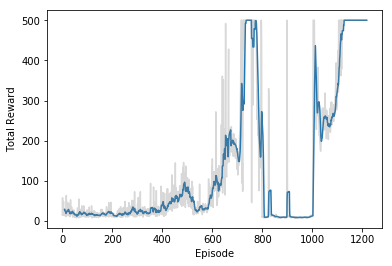

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [16]:
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for _ in range(10):
        state = env.reset()
        total_reward = 0
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, 
                           feed_dict={model.inputs: state.reshape([1, -1])})
                           #feed_dict={model.inputs: state.reshape((1, *state.shape))})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        print('total_reward:{}'.format(total_reward))

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0
total_reward:500.0


In [17]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.